#### The following script uses the PicoSDK & Picotech's python wrappers to implement the Picoscope's streaming mode. <br> https://www.picotech.com/downloads <br> https://github.com/picotech/picosdk-python-wrappers

## Set Up

#### Import Libraries

In [1]:
import ctypes
import numpy as np
from picosdk.ps5000a import ps5000a as ps
import matplotlib.pyplot as plt
import time
import datetime
import os
from scipy.signal import hilbert
from scipy.io import savemat
from scipy import signal
from picosdk.functions import adc2mV, assert_pico_ok, mV2adc
from IPython import display
from zipfile import ZipFile
np.set_printoptions(threshold=np.inf)

#### Experiment-Dependent Inputs

In [2]:
amplitudeRange = 233 # mVpp

#### Calibration-Dependent Inputs

In [3]:
# If reclibrated - replace value below with new Average Amp value in excel sheet
totalAmplification = 4.78 # dB

# If recalibrated - replace equation below with line of best fit between Vin and peak Vcouple 
expectedPeakVolts = ((0.8628*amplitudeRange) +  0.1018) # millivolts

# If recalibrated - replace equation below with line of best fit between Vin and PNP in Pa
expectedPNP =  int((5151.5*amplitudeRange) - 1353.3) # Pascals

# If recalibrated - replace values below with values from line of best fit between Vcouple and PNP in Pa
acquiredPNPslope = 5969 # slope for line of best of fit between Vcouple and pressure in pascals
acquiredPNPintercept = 797.39 # y-int for line of best of fit between Vcouple and pressure in pascals

#### Fixed Inputs

In [4]:
# Constants
lengthOfAcq = 40 # length of acquisition in seconds
samplingRate = 15e05 # sampling rate of signal in Hz
totalSamples = int(samplingRate*lengthOfAcq) # total number of samples collected during acquisition
numBuffersToCapture = lengthOfAcq # number of buffers set to equal length of acq so there is one buffer per second
sizeOfOneBuffer = int(totalSamples/numBuffersToCapture) # number of samples collected in each buffer
dsf = 1000 # downsampling factor to be used in hilbert envelope

# Waveform Characteristics: dont change unless using different waveform 
freq = 250 # kHz
burstPeriod = 0.03 # burst of ultrasound in seconds
lengthOfOneCylce = 0.1 # total time for each cycle in seconds, each 30ms burst occurs every 100ms
noOfCylces = burstPeriod*freq*1e-03 # number of cylces per burst
dutyCycle = (burstPeriod/lengthOfOneCylce) # in decimals, duty cycle of bursts as a ratio

## Set up PicoScope parameters

#### Set up Picoscope

In [4]:
# Create chandle and status ready for use
chandle = ctypes.c_int16()
status = {}

# Open PicoScope 5000 Series device
resolution =ps.PS5000A_DEVICE_RESOLUTION["PS5000A_DR_12BIT"] # Resolution set to 12 Bit
status["openunit"] = ps.ps5000aOpenUnit(ctypes.byref(chandle), None, resolution) # handle to chandle for use in API functions

try:
    assert_pico_ok(status["openunit"])
except: # PicoNotOkError:

    powerStatus = status["openunit"]

    if powerStatus == 286:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    elif powerStatus == 282:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    else:
        raise

    assert_pico_ok(status["changePowerSource"])

#### Set up ChA for acquisition

In [6]:
# Constants
enabled = 1
disabled = 0
analogue_offset = 0.0
channel_range = ps.PS5000A_RANGE['PS5000A_500MV']

status["setChA"] = ps.ps5000aSetChannel(chandle,
                                        ps.PS5000A_CHANNEL['PS5000A_CHANNEL_A'],
                                        enabled,
                                        ps.PS5000A_COUPLING['PS5000A_DC'],
                                        channel_range,
                                        analogue_offset)
assert_pico_ok(status["setChA"])

#### Set up buffers for data acquisition

In [7]:
# Set up Buffer A on Channel A
bufferAMax = np.zeros(shape=sizeOfOneBuffer, dtype=np.int16) # Create buffer array for data collection
memory_segment = 0
status["setDataBuffersA"] = ps.ps5000aSetDataBuffers(chandle,
                                                     ps.PS5000A_CHANNEL['PS5000A_CHANNEL_A'],
                                                     bufferAMax.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
                                                     None,
                                                     totalSamples,
                                                     memory_segment,
                                                     ps.PS5000A_RATIO_MODE['PS5000A_RATIO_MODE_NONE'])
assert_pico_ok(status["setDataBuffersA"])

## Start streaming on the picoscope & data acquisition

#### Set up trigger that occurs at first detected rising edge

In [8]:
# Set up mV Conversion
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps5000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

In [9]:
# Set up single trigger
enabled = 1
source = ps.PS5000A_CHANNEL["PS5000A_EXTERNAL"] # trigger on the external channel on the picoscope
threshold = int(mV2adc(20,channel_range, maxADC)) # threshold set to 20 mV
direction = 2 # PS5000A_RISING, trigger on the rising edge
delay = 0 # no delay between trigger and rising edge
autoTrigger = 0 # set to 0, makes picoscope wait indefinitely for a rising edge
status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 
                                               enabled, 
                                               source, 
                                               threshold, 
                                               direction, 
                                               delay, 
                                               autoTrigger)
assert_pico_ok(status["trigger"])

#### Begin streaming mode on PicoScope

In [10]:
sampleInterval = ctypes.c_int16(int((1/samplingRate)*1e09)) # sampling interval in nanoseconds
sampleUnits = ps.PS5000A_TIME_UNITS['PS5000A_NS']
maxPreTriggerSamples = 0 # no samples collected before the trigger
autoStopOn = 1
downsampleRatio = 1 # no downsampling
status["runStreaming"] = ps.ps5000aRunStreaming(chandle,
                                                ctypes.byref(sampleInterval),
                                                sampleUnits,
                                                maxPreTriggerSamples,
                                                totalSamples,
                                                autoStopOn,
                                                downsampleRatio,
                                                ps.PS5000A_RATIO_MODE['PS5000A_RATIO_MODE_NONE'],
                                                sizeOfOneBuffer)
assert_pico_ok(status["runStreaming"])

#### Define callback function that acquires and reports signal data

In [11]:
# Set up variables for loop
bufferCompleteA = np.zeros(shape=totalSamples, dtype=np.int16) # buffer not registered with driver to hold all of buffers collected
nextSample = 0
autoStopOuter = False
wasCalledBack = False
bufferEnd = [0]
rmsArray = []
timeArray = []
count = 0

def streaming_callback(handle, noOfSamples, startIndex, overflow, triggerAt, triggered, autoStop, param):
    global nextSample, autoStopOuter, wasCalledBack, count, trigIdx, rmsExpected
    # Prevent loop from continuing until a trigger is detected
    if triggered!=0:
        trigIdx = triggerAt
        count=1
    # Once trigger is detected, move forward with indexing
    if count==1:
        wasCalledBack = True
        sourceEnd = startIndex + noOfSamples
        noOfSamplesPostTrigger = noOfSamples-triggerAt
        destEnd = nextSample + noOfSamplesPostTrigger
        bufferCompleteA[nextSample:destEnd] = bufferAMax[(startIndex+triggerAt):sourceEnd]
        # Compute, store, and plot the RMS voltages for every # data points equal to sampling rate
        if sourceEnd==sizeOfOneBuffer:
            bufferEnd.append(destEnd)                    
            rmsBuffer = bufferCompleteA[bufferEnd[-2]:bufferEnd[-1]] # select values from each complete buffer as acquired
            # Calculate RMS voltage for each buffer that should be seen on real-time plot below
            rmsExpected = (((amplitudeRange/2)*(10**(totalAmplification/20)))/np.sqrt(2))*np.sqrt(dutyCycle) # mVp
            # Calculate RMS voltage being measured for each buffer
            rms = [np.sqrt(np.mean(np.array(rmsBuffer, dtype='int64')**2))] # compute RMS Voltage of each buffer from ChA
            rmsVoltage = adc2mV(rms, channel_range, maxADC) # function that converts bits to voltages from ChA
            rmsArray.append(rmsVoltage) # build array of each RMS voltage from Channel A
            time = (lengthOfAcq/numBuffersToCapture)*len(rmsArray) 
            timeArray.append(time)
            # Plot in real-time
            plt.plot(timeArray, rmsArray,'k-')
            plt.xlabel('Time (s)')
            plt.ylabel('Voltage (mV)')
            plt.title("RMS Voltage that Should be Expected is ~ %0.2f mV" %rmsExpected)            
            display.display(plt.gcf())
            display.clear_output(wait=True)
        nextSample += noOfSamplesPostTrigger
        if autoStop:
            autoStopOuter = True
            
cFuncPtr = ps.StreamingReadyType(streaming_callback) # Convert the python function into a C function pointer.

#### Run loop that collects complete buffer data and RMS voltages for each buffer

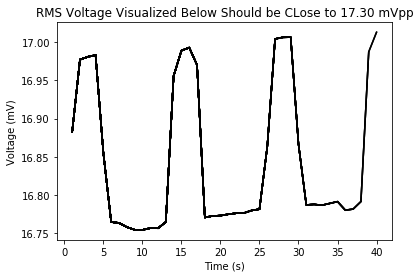

In [12]:
# While loop to collect data and perform desired calculations and plots
while nextSample < totalSamples and not autoStopOuter:
    wasCalledBack = False
    status["getStreamingLastestValues"] = ps.ps5000aGetStreamingLatestValues(chandle, cFuncPtr, None)

# Plot RMS voltages at the end to keep plot visible to user
fig1 = plt.figure(1);
plt.plot(timeArray, rmsArray,'k-');
plt.xlabel('Time (s)');
plt.ylabel('Voltage (mV)');
plt.title("RMS Voltage Visualized Below Should be CLose to %0.2f mV" %rmsExpected);

#### Disconnect from the Picoscope so that new kernel may be connected to the Picoscope

In [13]:
# Stop the scope
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])

# Disconnect the scope
status["close"] = ps.ps5000aCloseUnit(chandle)
assert_pico_ok(status["close"])

## Post-processing

#### Extract the envelope of the signal from ChA using the Hilbert Function

In [14]:
analytical_signal = hilbert(bufferCompleteA)
amplitude_envelope = np.abs(analytical_signal)

#### Downsample voltage data and time array for plotting

In [15]:
amplitude_ds = signal.resample_poly(amplitude_envelope,1,dsf) # signal.resample_poly(chA data, upsamplefactor, downsamplefactor)
time = np.linspace(0,lengthOfAcq,totalSamples) # time array in seconds
time_ds = signal.resample_poly(time,1,dsf) # downsample time array by same factor

#### Convert downsampled data from adc values to voltages

In [16]:
adc2mVChAMax = adc2mV(amplitude_ds, channel_range, maxADC) # function that converts to voltages

#### Plot envelop of signal from ChA

Peak voltage that should be expected is ~ 43.2 mVpp


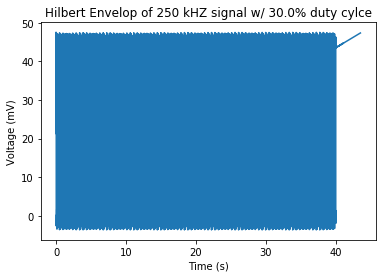

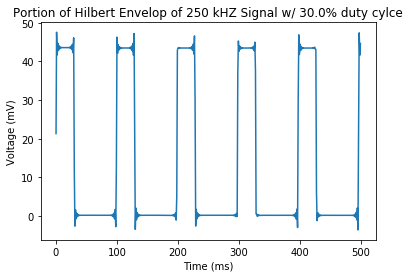

In [18]:
print("Peak voltage that should be expected is ~ %0.1f mV" %expectedPeakVolts)

# Plot hilbert envelope of the full signal
fig2 = plt.figure(2);
plt.plot(time_ds,adc2mVChAMax);
plt.xlabel('Time (s)');
plt.ylabel('Voltage (mV)');
plt.title('Envelop of '+str(freq)+ ' kHZ signal w/ ' +str(dutyCycle*100)+'% duty cylce');
# Plot hilbert envelope of part of signal
fig3 = plt.figure(3);
plt.plot(time_ds[0:500]*1000,adc2mVChAMax[0:500]);
plt.xlabel('Time (ms)');
plt.ylabel('Voltage (mV)');
plt.title('Envelop of Part of ' +str(freq)+ ' kHZ Signal w/ ' +str(dutyCycle*100)+ '% duty cylce');

## Compare predicted peak voltages, RMS voltage, & pressure values to acquired data

#### Compare acquired peak voltages to peak voltages that should be seen for the complete signal

In [19]:
print("Peak voltage that should be expected is ~ %0.1f mV" %expectedPeakVolts)

Peak voltage that should be expected is ~ 43.2 mVpp


In [20]:
peakVoltADC = [max(bufferCompleteA)] # collect max voltage in buffer array as estimate for peak voltage of the array
acquiredPeakVolts = adc2mV(peakVoltADC, channel_range, maxADC)
acquiredPeakVolts = acquiredPeakVolts[0]

# This value will be slightly higher than predicted and than is seen in the plot above becuase it collects the buffer's 
    # overall max amplitude value and uses that as the "peak voltage" value
print("Peak Voltage of acquired signal is ~ %0.1f mV" %acquiredPeakVolts)

Peak Voltage of acquired signal is ~ 45.0 mVpp


In [21]:
voltageVals = [expectedPeakVolts, acquiredPeakVolts]

#### Compare acquired RMS voltage to correct RMS voltage

In [22]:
rmsExpected = (((amplitudeRange/2)*10**(totalAmplification/20))/np.sqrt(2))*np.sqrt(dutyCycle) # expected val
print("RMS Voltage that should be expected is ~ %0.1f mV" %rmsExpected)

RMS Voltage that should be expected is ~ 17.4 mVpp


In [23]:
rmsActual = np.mean(rmsArray) # estimate measured rms voltage by taking average of rms values determined for each buffer

# This value will be slightly lower than predicted above
print("Average RMS Voltage of acquired signal is ~ %0.1f mV" %rmsActual)

Average RMS Voltage of acquired signal is ~ 16.8 mVpp


In [24]:
rmsVals = [rmsExpected, rmsActual]

#### Compare approximate acquired pressure to correct pressure values

In [25]:
print('Presure that should be expected at input voltage of ' +str(amplitudeRange)+ ' mVpp is ~ ' +str(expectedPNP/1000)+ ' kPa')

Presure that should be expected at input voltage of 50 mVpp is ~ 256.221 kPa


In [26]:
acquiredPNP = int((acquiredPNPslope*acquiredPeakVolts) + acquiredPNPintercept) # in pascals
print('Pressure of acquired signal at input voltage of ' +str(amplitudeRange)+ ' mVpp is ~ ' +str(acquiredPNP/1000)+ ' kPa')

Pressure of acquired signal at input voltage of 50 mVpp is ~ 284.516 kPa


In [27]:
pressureVals = [expectedPNP,acquiredPNP]

## Save Buffer Data, Hilbert Envelop of Data & RMS Voltages for Each Buffer

In [28]:
# save data to a .mat file as a struct holding time, voltages, correct peak voltage, rms voltage, and correct rms voltage
mdic = {"timeDataSEC": time_ds, "signalEnvelopeMV": adc2mVChAMax, "signalAmplitudeComparisonValMV": voltageVals[0], 
        "rmsDataMV": rmsArray, "rmsVoltageComparisonValMV": rmsVals[0]}

ct = datetime.datetime.now() 
timestamp = str(ct.strftime("%Y%m%d_%H%M%S"))

filename = "completeData"+timestamp+".mat"
savemat(filename, mdic)

# uncomment line below if need to rewrite folder, leave commented if want to collect files for each run
#os.remove('Python.zip') 

zipObj = ZipFile('PowerMonitor.zip', 'a') # struct saved to a zip file named PowerMonitor.zip
zipObj.write(filename)
zipObj.close()
os.remove(filename)